# Pause Detection

## Python 3 Kernel - Trajectory Simulation

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd
import itertools

In [2]:
%matplotlib inline

In [3]:
random.seed(53)
np.random.seed(53)

In [4]:
def pausegen_fastversion(event_duration,
             rate,
              pause_duration,
              noise_sigma,
              ntraj):
    rate_sequence = [rate]*int(event_duration)
    pause_start = int(event_duration/2 - pause_duration/2)
    pause_end = pause_start + pause_duration
    rate_sequence[pause_start:pause_end] = [0]*pause_duration
    position = np.cumsum(rate_sequence)
    position = np.tile(position, ntraj)                           
    position_withnoise = np.array(position) + np.random.normal(loc=0, scale = noise_sigma, size = event_duration*ntraj)
    time = np.tile(range(0, event_duration), ntraj)
    trajseq = np.repeat(range(0,ntraj), event_duration)
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : position_withnoise,
                           'position' : position,
                           'trajectory' : trajseq})
    return results;

In [5]:
def pause_dataset(event_duration = 100, noise_sigma = 100, ntraj = 10000):
    
    rates = [50, 100, 150, 200]
    for j in rates:
        for i in range(1,21):
            pause_duration = i
            data = pausegen_fastversion(event_duration,
                 j,
                  pause_duration,
                  noise_sigma,
                  ntraj)
            data.to_csv(str(j)+'_'+str(pause_duration)+'_pause.csv', index=False, columns=['time', 'nucleotides', 'trajectory', 'position'])       
    return 0;

In [6]:
pause_dataset()

0

## Julia 0.6 Kernel - Change Point Analysis

Now switich to the Julia 0.6 kernel, import the change point functions and run change point analysis.

In [1]:
include("../src/KineticChangepoints.jl")

getchangepoints (generic function with 3 methods)

In [2]:
for j in collect(50:50:200)
    for i in collect(1:1:20)
        sourcefile = string(j, "_", i, "_pause.csv")
        outputfile = string(j, "_", i, "_segs_pause.csv")
        getchangepoints(sourcefile, outputfile, 100, 0.99, ',', [1, 2, 3]);
    end
end

## R Kernel - Analysis and Plots

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(svglite)))

In [2]:
filelist = c()
for (j in seq(4)){
    rval = j*50
    minfilelist = c()
    for (i in seq(1,20,1)){
        minfilelist = append(minfilelist, paste0(rval, "_", i,"_segs_pause.csv"))
        }
    filelist = append(filelist, minfilelist)
    }
rm(i, j, minfilelist, rval)

In [3]:
listy <- list()
for (i in 1:length(filelist)){
    tmp <-  read.csv(filelist[i])
    tmp <- tmp %>%
        mutate(tablenumber = i)
    listy[[i]] <- tmp
    }

We define the criterion for pause detection as the presence of a segment of rate lower than 20 position units/time units, which passes through the centre of the trajectory (i.e. where the pause is).

In [4]:
detectioncount <- c()
for (i in 1:length(listy)){
    tmp <- listy[[i]] %>%
        filter(B < 20) %>%
        summarise(ndetected = length(unique(trajectory))) #This is counting segments with rates of less than 20
    detectioncount <- append(detectioncount, tmp$ndetected)
    }
detectioncount = unlist(detectioncount)

In [5]:
ratelist <- c(rep(50,20),rep(100,20),rep(150,20),rep(200,20))

pauseduration <- c(rep(seq(1,20,by=1),4))
resultframe <- data.frame(ratelist, pauseduration, detectioncount)

In [6]:
singlecount <- c()	
meansingleposlist <- c()
for (i in 1:length(listy)){
        tmp <- listy[[i]] %>%
        group_by(trajectory) %>%
        mutate(ndetected = n() - 1) %>%
        filter(ndetected == 1) %>%
        ungroup() %>%
        summarise(count = n(), meanpos = mean(x1))
    singlecount <- append(singlecount, tmp$count)
    meansingleposlist <- append(meansingleposlist, tmp$meanpos)
    }
singlecount = unlist(singlecount)
meansingleposlist = unlist(meansingleposlist)

In [7]:
resultframe$singlecptcount <- singlecount
resultframe$meansinglepos <- meansingleposlist

In [8]:
meancountlist <- c()
mediancountlist <- c()
for (i in 1:length(listy)){
    tmp <- listy[[i]] %>% group_by(trajectory) %>%
    summarise(ndetected = n() - 1) %>%
    ungroup() %>%
    summarise(meandetected = mean(ndetected), mediancount = median(ndetected))
    meancountlist <- append(meancountlist, tmp$meandetected)
    mediancountlist <- append(mediancountlist, tmp$mediancount)
    }
meancountlist = unlist(meancountlist)
mediancountlist = unlist(mediancountlist)
resultframe$meancount <- meancountlist
resultframe$mediancount <- mediancountlist

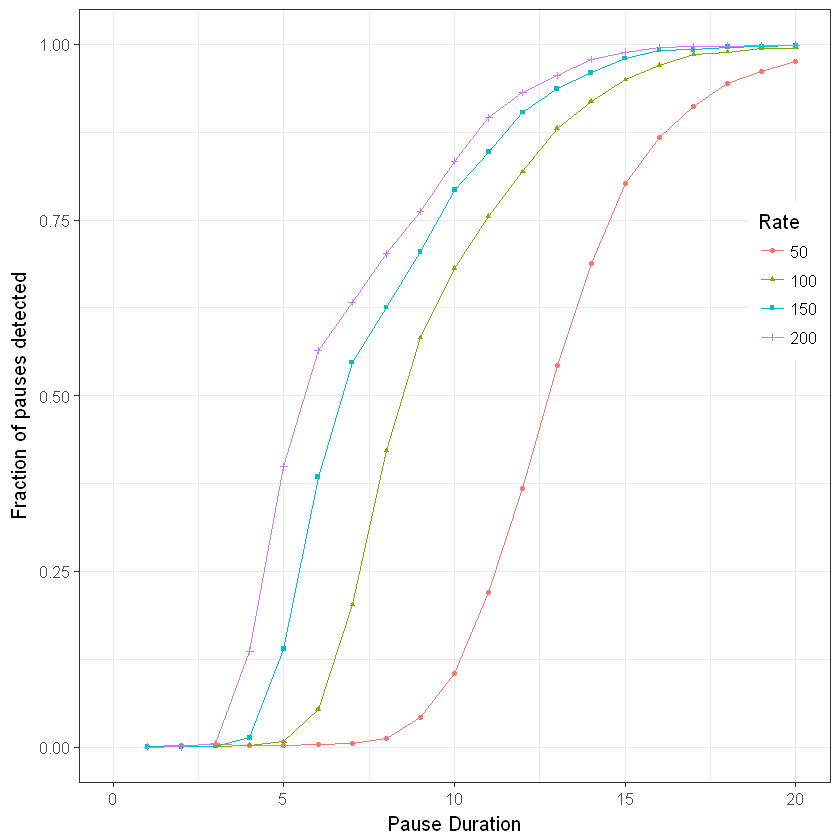

In [9]:
pauselist <- c(rep(seq(1,20,by=1),4))
pausesdetected <- ggplot(resultframe, aes(x=pauselist, y = detectioncount/10000, 
                                          group = factor(ratelist),
                                          shape = factor(ratelist),
                                          colour = factor(ratelist)))+
                geom_point(size = 1)+
                geom_line(size = 0.5)+
                theme_bw(12)+
                scale_colour_discrete("Rate")+
                scale_shape("Rate")+
                scale_x_continuous(limits = c(0,20))+
                labs(x = "Pause Duration", y = "Fraction of pauses detected")+
                theme(legend.position=c(1,0.75),legend.justification = c(1, 1))
                #ggsave("pausesdetected.png", pausesdetected, dpi = 600)
pausesdetected

In [10]:
svglite(file = "pausesdetected.svg", width = 3.3, height = 3.3)
pausesdetected
dev.off()

png 
  2

In [124]:
measuredduration <- c()
durationsd <- c()
durationse <- c()
for (i in 1:length(listy)){
tmp <- listy[[i]] %>%
filter(B < 20 & x2 > 49 & x1 < 50) %>%
        summarise(meanduration = mean(duration, na.rm = TRUE),
                  sdduration = sd(duration, na.rm = TRUE),
                 count = n(),
                 seduration = sdduration/(count^0.5))
        measuredduration <- append(measuredduration, tmp$meanduration)
        durationsd <- append(durationsd, tmp$sdduration)
        durationse <- append(durationse, tmp$seduration)
}
measuredduration <- unlist(measuredduration)
durationsd <- unlist(durationsd)
durationse <- unlist(durationse)
resultframe2 <- data.frame(ratelist, pauselist, detectioncount, measuredduration, durationsd, durationse)
resultframe2$discrepancy = with(resultframe2, measuredduration - pauselist)
#resultframe2 <- resultframe2 %>% filter(detectioncount > 5000) 

Warning message:
"Removed 20 rows containing missing values (geom_point)."Warning message:
"Removed 20 rows containing missing values (geom_path)."

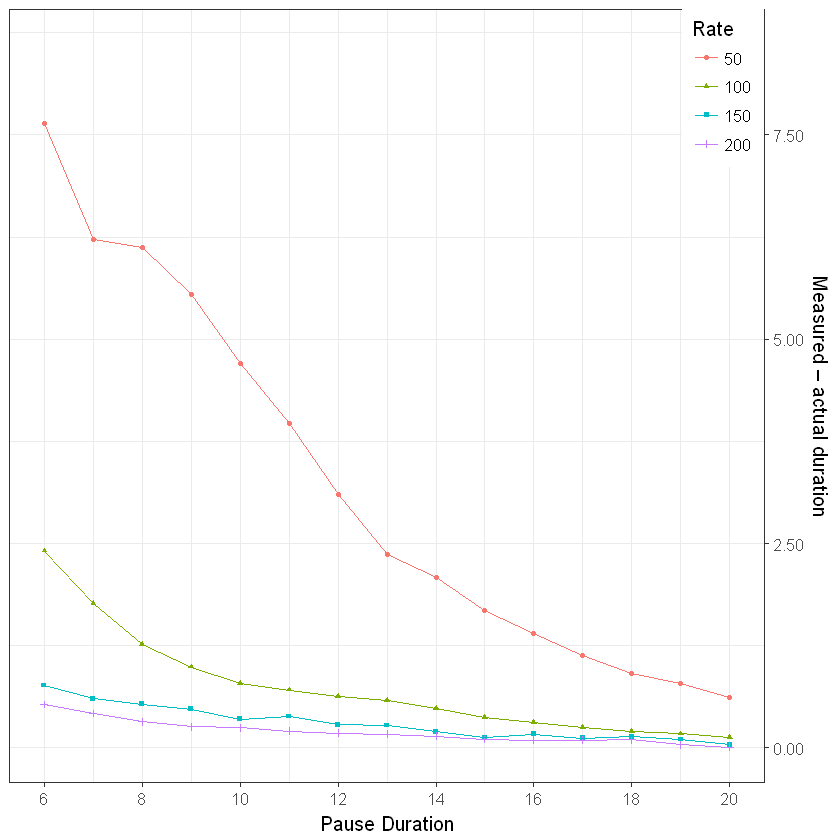

In [121]:
scaleFUN <- function(x) sprintf("%.2f", x)
discrepancyplot <- ggplot(resultframe2, aes(x=pauselist, 
                                            y = discrepancy,
                                            shape = factor(ratelist), 
                                            group = factor(ratelist), 
                                            colour = factor(ratelist)))+
            geom_point(size = 1)+
            geom_line(size = 0.5)+
            scale_colour_discrete("Rate")+
            scale_shape("Rate")+
            theme_bw(12)+
            labs(x = "Pause Duration", y = "Measured \u2013 actual duration")+
            scale_x_continuous(limits = c(6,20), breaks = seq(6,20,2))+
            scale_y_continuous(labels=scaleFUN, position = "right")+
            #theme(legend.position="none")
            theme(legend.position=c(1,1),legend.justification = c(1, 1))
            #ggsave("discrepancyplot.png", discrepancyplot, dpi = 600)
discrepancyplot

In [125]:
svglite(file = "discrepancyplot.svg", width = 3.3, height = 3.3)
discrepancyplot
dev.off()

Warning message:
"Removed 20 rows containing missing values (geom_point)."Warning message:
"Removed 20 rows containing missing values (geom_path)."

png 
  2

### Example plots

In [61]:
rate50pause10 <- read.csv("50_10_pause.csv")
rate100pause8 <- read.csv("100_8_pause.csv")
rate150pause6 <- read.csv("150_6_pause.csv")
rate200pause6 <- read.csv("200_6_pause.csv")

In [62]:
t_rate50pause10 <- rate50pause10 %>% filter(trajectory == 0)
t_rate100pause8 <- rate100pause8 %>% filter(trajectory == 0)
t_rate150pause6  <- rate150pause6 %>% filter(trajectory == 0)
t_rate200pause6 <- rate200pause6 %>% filter(trajectory == 0)

In [63]:
segs_rate50pause10 <- listy[[10]] %>% filter(trajectory == 0)
segs_rate100pause8 <- listy[[28]] %>% filter(trajectory == 0)
segs_rate150pause6 <- listy[[46]] %>% filter(trajectory == 0)
segs_rate200pause6 <- listy[[56]] %>% filter(trajectory == 0)

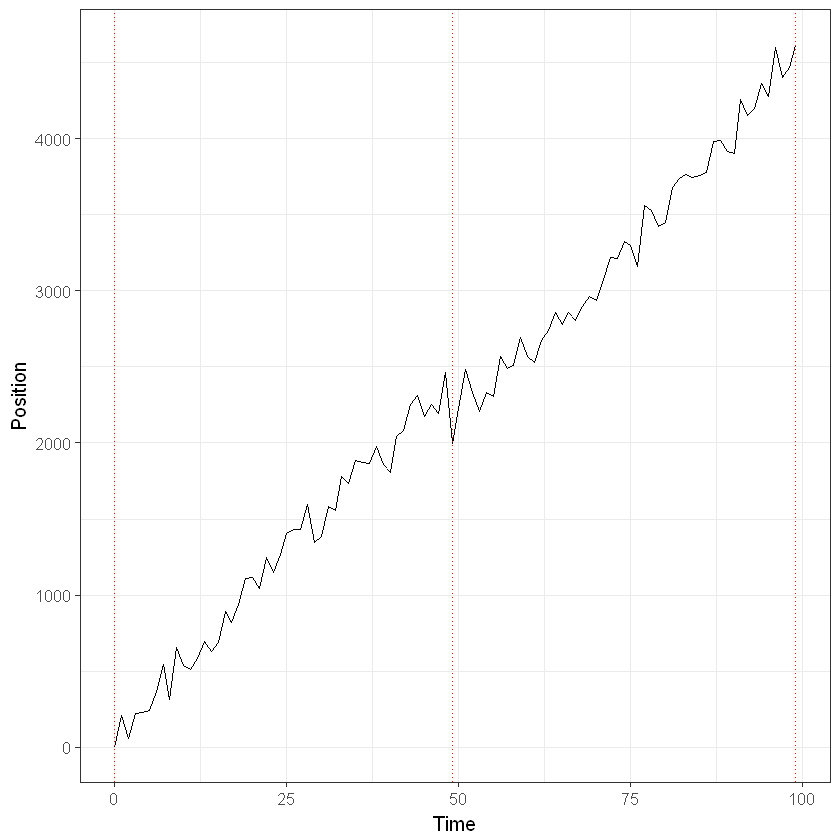

In [98]:
rate50pause10_plot <- ggplot(t_rate50pause10, aes(x = time))+
    geom_line(size = 0.5, aes(y = nucleotides))+
    #geom_line(size = 0.5, aes(y = position), colour = "blue")+
    theme_bw(12)+
    scale_y_continuous(position = "left")+
    geom_vline(xintercept = c(0,segs_rate50pause10$x2), linetype = "dotted", colour = "red")+
    labs(x = "Time", y = "Position")
rate50pause10_plot

In [99]:
svglite(file = "rate50pause10_plot.svg", width = 3.3, height = 3)
rate50pause10_plot
dev.off()

png 
  2

In [115]:
rate100pause14 <- read.csv("100_14_pause.csv")
t_rate100pause14 <- rate100pause14 %>% filter(trajectory == 0)
segs_rate100pause14 <- listy[[34]] %>% filter(trajectory == 0)

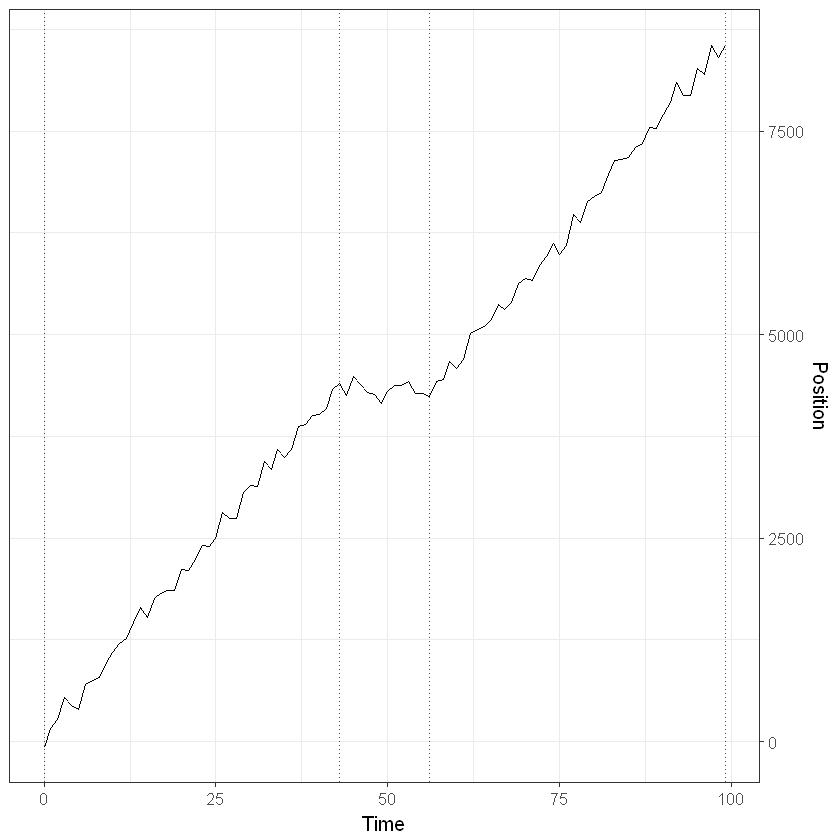

In [118]:
rate100pause14_plot <- ggplot(t_rate100pause14, aes(x = time))+
    geom_line(size = 0.5, aes(y = nucleotides))+
    #geom_line(size = 0.5, aes(y = position), colour = "blue")+
    theme_bw(12)+
    scale_y_continuous(position = "right")+
    geom_vline(xintercept = c(0,segs_rate100pause14$x2), linetype = "dotted", colour = "red")+
    labs(x = "Time", y = "Position")
rate100pause14_plot

In [119]:
svglite(file = "rate100pause14_plot.svg", width = 3.3, height = 3)
rate100pause14_plot
dev.off()

png 
  2